In [46]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.misc

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from mrcnn import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory of images to run detection on
TEST_IMAGE_DIR = "/scratch/at3577/cvpr/test/"
OUTPUT_DIR = "/scratch/at3577/cvpr/predictions/"

(2710, 3384, 3)


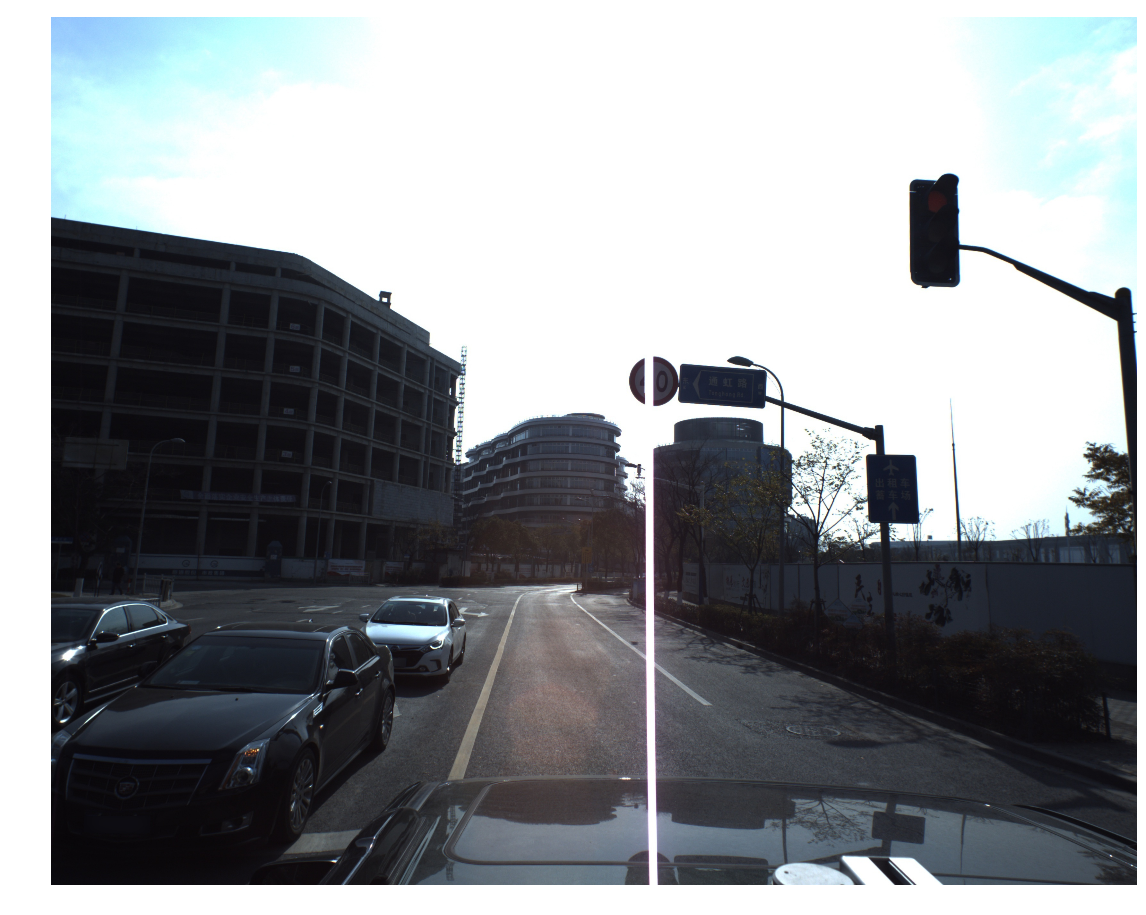

In [47]:
# Load a random image from the images folder
random_image_file = random.choice(next(os.walk(TEST_IMAGE_DIR))[2])
image = skimage.io.imread(os.path.join(TEST_IMAGE_DIR, random_image_file))
print image.shape
visualize.display_images([image],cols=1)

In [48]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

In [49]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [50]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[ 102    0  922 1024]
Number of predictions
7


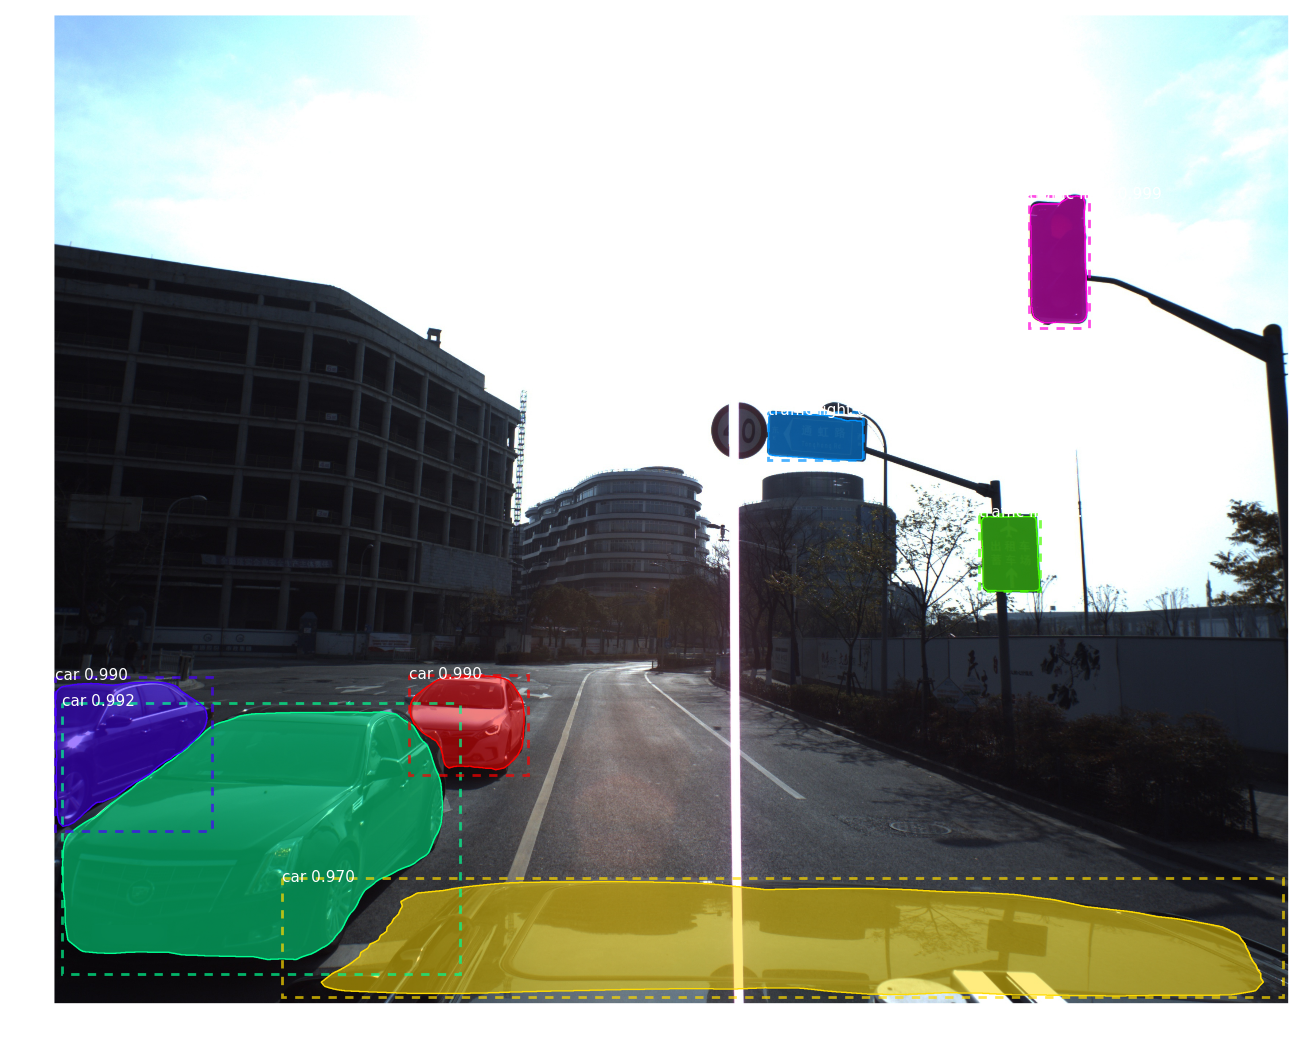

In [51]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [45]:
TEST_IMAGE_LIST_MAPPING = '/scratch/at3577/cvpr/test_video_list_and_name_mapping/list_test_mapping/'
image_mapping_dataframe = pd.DataFrame([])
for filename in os.listdir(TEST_IMAGE_LIST_MAPPING):
    df = pd.read_csv(os.path.join(TEST_IMAGE_LIST_MAPPING, filename),
                     sep='\t',
                     header=None,
                     names=['actual_names','video_list_names'])
    df['actual_names'] = df['actual_names'] + '.jpg'
    df['video_list_names'] = df.apply(lambda row : row['video_list_names'].split('\\')[-1], axis=1)
    image_mapping_dataframe = image_mapping_dataframe.append(df)

In [46]:
def get_video_list_name(actual_name):
    return image_mapping_dataframe[image_mapping_dataframe['actual_names']==actual_name]['video_list_names'].to_string(index=False)

def get_actual_name(video_list_name):
    return image_mapping_dataframe[image_mapping_dataframe['video_list_names']==video_list_name]['actual_names'].to_string(index=False)

In [19]:
# ~~~~~~~~~~~~~~~~~10 images are not in here~~~~~~~~~~~~

In [64]:
coco_to_cvpr_mapping = {
        3: 33,
        4: 34,
        2: 35,
        1: 36,
        8: 38,
        6: 39
    }

def convert_to_cvpr_class(coco_class):
#   3 car, 33
#   4 motorbicycle, 34
#   2 bicycle, 35
#   1 person, 36
#   rider, 37
#   8 truck, 38
#   6 bus, 39
#   tricycle, 40
    return coco_to_cvpr_mapping[coco_class]

In [23]:
for index, row in image_mapping_dataframe.iterrows():
    image_file = os.path.join(TEST_IMAGE_DIR, row['actual_names'])
    image = skimage.io.imread(image_file)
    video_list_filename, _ = os.path.splitext(row['video_list_names'])
    
    # Run detection
    results = model.detect([image], verbose=0)

    # Save results
    result = results[0]
    num_results = result['masks'].shape[2]
    
    predictions_dataframe = pd.DataFrame([])
    for i in range(num_results):
        if result['class_ids'][i] not in coco_to_cvpr_mapping.keys():
            continue
            
        masked_image = scipy.misc.toimage(result['masks'][:,:,i], cmin=0.0, cmax=1.0)
        masked_image_file_name = video_list_filename + '_mask_' + str(i) + '.jpg'
        masked_image.save(os.path.join(OUTPUT_DIR,masked_image_file_name), "JPEG")
        
        class_id = convert_to_cvpr_class(result['class_ids'][i])
        score = result['scores'][i]
        predictions_dataframe = predictions_dataframe.append([[masked_image_file_name, class_id, score]])
    
    prediction_file_name = os.path.join(OUTPUT_DIR, video_list_filename + '_instanceIds.txt')
    predictions_dataframe.to_csv(prediction_file_name, sep='\t', index=False, header=None)
    

NameError: name 'image_mapping_dataframe' is not defined